In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import imp
import sys
import scipy
import pickle as plk
import importlib.util
from numpy.lib.scimath import sqrt as csqrt
from IPython.display import display, Math, clear_output
from scipy.signal import find_peaks

###############################################################
#LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/media/leonardo/datam02/Edge-Coupler')) #Current directory

###############################################################
#WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Leo/Documents/Facul/Capacitação/GitHub/Edge-Coupler'))
spec_win.loader.exec_module(lumapi)


def imbalance(n,p):
    return 10*np.log10(p/n)

def CMRR(n,p):
    return 20*np.log10(abs((p-n)/(p+n)))

def functionstapers(lenght, N, width, function): # Generate polygons with the given function
    yinverse = np.flip(-function)
    xinverse = np.linspace(lenght,0,N)
    X = np.append(x,xinverse)
    Y = np.append(function,yinverse)
    vertices = np.column_stack((X,Y))
    lum.addpoly()
    lum.set('vertices',vertices)
    return X, Y, xinverse, yinverse

# Parameters and variables

core = 'Si (Silicon) - Palik'
substract = 'SiO2 (Glass) - Palik'

height = 0.34e-6
burriedlayer = 2e-6
finalwidth = 0.55e-6

Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
band = np.linspace(1500e-9, 1600e-9, 2000)
c0 = 299792458

width = 0.04e-6
length = 200e-6
N = 100

time = 5e-12

yspan = 25e-6
zspan = 25e-6
substratez = 4e-6 + height

fdtd = 0 # if 0 to open mode and generate eme, 1 to open and generate FDTD

C:\Users\Leo\AppData\Local\Temp\ipykernel_27900\3796420603.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


# Linear

In [2]:
if (fdtd): lum = lumapi.FDTD(filename='../CML/Linear.fsp')
else: lum = lumapi.MODE(filename='../CML/Linear.lms')

In [3]:
# Using 0.04μm width for TM and 0.08μm for TE
# Using 200μm lenght
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()
lum.select('extension')
lum.delete()
lum.select('fiber')
lum.delete()

width = 0.08e-6
x = np.linspace(0,length,N)
m = (width-finalwidth)/(length-0)/2
function = m*x + finalwidth/2
inversefunction = function[::-1]

functionstapers(length, N, width, inversefunction)
lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : substratez,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : yspan,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})

lum.addobject('cc_fiber')
lum.set({
    'first axis'  :  'y',
    'rotation 1': 90,
    'index cladding' : 1.46,
    'index core'     : 1.47,
    'radius core'    : 4e-6,
    'radius cladding': 20e-6,
    'z span'         : 20e-6,
    'z'              : height/2,
    'x'              : -10e-6,
    'y'              : 0,
    'name'           : 'fiber'
})

In [4]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)
lum.switchtolayout()
meshmulti = 3
cellsmesh = 250
lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()
lum.select('EME')
lum.delete()
lum.select('full coupler mesh')
lum.delete()
lum.select('extension mesh')
lum.delete()
lum.select('high order mesh')
lum.delete()


if fdtd:
    # Create FDTD
    lum.addpower()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 5e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addpower()
    lum.set('monitor type', '2D X-normal')
    lum.set({
        'z'                               : height/2,
        'z span'                          : zspan,
        'x'                               : length + 2e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'output',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addmode()
    lum.set({
        'x'                : -2.5e-6,
        'y'                : 0,
        'y span'           : yspan,
        'z'                : height/2,
        'z span'           : zspan,
        'name'             : 'port',
        'wavelength start' : 1.5e-6,
        'wavelength stop'  : 1.6e-6
    })

    lum.addfdtd()
    lum.set({
        'z'               : height/2,
        'z span'          : zspan,
        'x'               : length/2,
        'x span'          : length+5e-6,
        'y'               : 0,
        'y span'          : yspan,
        'mesh accuracy'   : 2,
        'y min bc'        : 'PML',
        'z min bc'        : 'Symmetric',
        'y max bc'        : 'PML',
        'z max bc'        : 'PML',
        'simulation time' : time
    })

    
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'core',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'extension',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })

else:

    # Create EME 
    lum.addeme()
    lum.set("allow custom eigensolver settings",1)
    lum.set("number of cell groups",3)
    lum.set("group spans",np.transpose([5e-6, length, 4e-6]))
    lum.set({
        "cells"                   :np.transpose([1,80, 1]),
        "subcell method"          :np.transpose([0, 1, 0]), # 0 = none,  1 = CVCS
        "modes"                   :np.transpose([4, 32, 4]),
        "x min"                   :-5e-6,
        "y"                       :0,
        "y span"                  :yspan,
        "z"                       :height/2,
        "z span"                  :zspan,
        "y min bc"                :"Anti-Symmetric",
        "y max bc"                :"PML",
        "z min bc"                :"Symmetric",
        "z max bc"                :"PML",
        #"background material"     :"SiO2 (Glass) - Palik",
        "mesh cells y"            :cellsmesh,
        "mesh cells z"            :cellsmesh,
        "display cells"           : 0
        })
    
    lum.addemeprofile()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 10e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
    })

    #Create EME Ports
    lum.select("EME::Ports::port_2")
    lum.set({"use full simulation span" :0,
        "y span"                        :2e-6,
        "z span"                        :4e-6,
        "z"                             :height/2
    })

    lum.select("EME::Ports::port_1")
    lum.set({"use full simulation span" :0,
        "y span"                        :yspan,
        "z span"                        :zspan,
        "z"                             :height/2,
    })

    lum.addmesh()
    lum.set({
        'based on a structure': 1,
        'structure'           : 'core',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti,
        'name'                : 'full coupler mesh'
        })
    lum.addmesh()
    lum.set({
        'based on a structure': 1,
        'structure'           : 'extension',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti,
        'name'                : 'extension mesh'
    })
    lum.addmesh()
    lum.set({
        'name'   : 'high order mesh',
        'x'      : 25e-6,
        'x span' : 50e-6,
        'y'      : 0,
        'y span' : 0.15e-6,
        'z'      : 0,
        'z span' : 0.4e-6,
        'dx'     : 0.003e-6,
        'dy'     : 0.003e-6,
        'dz'     : 0.006e-6,
    })



In [11]:
# Create FDE 
cellsmesh = 400

if fdtd == 0 :
    lum.select('FDE')
    lum.delete()
    lum.addfde()
    lum.set('solver type', '2D X normal')
    lum.set({
        "mesh cells y" :cellsmesh,
        "mesh cells z" :cellsmesh,
        "x"            : 0,
        'y'            : 0,
        'z'            : height/2,
        'y span'       : yspan,
        'z span'       : zspan,
        "y min bc"     :"PML",
        "y max bc"     :"PML",
        "z min bc"     :"PML",
        "z max bc"     :"PML",                       
    })

In [8]:
# Number of cells calculation by using FDE index in this sweep

x_sweep = np.arange(80e-6,120.1e-6,1e-6)
neffsweep = np.zeros(len(x_sweep),dtype='complex')
for i in range(len(x_sweep)):
    lum.switchtolayout()
    lum.setnamed('FDE', 'x', x_sweep[i])
    lum.run()
    lum.setanalysis('number of trial modes', 2)
    lum.findmodes()
    aux = lum.getdata('mode1','neff')
    neffsweep = aux[0][0]

LumApiError: "in getdata, the d-card named mode1 was not found.\n  Try the command '?getdata;' to see which d-cards are available."

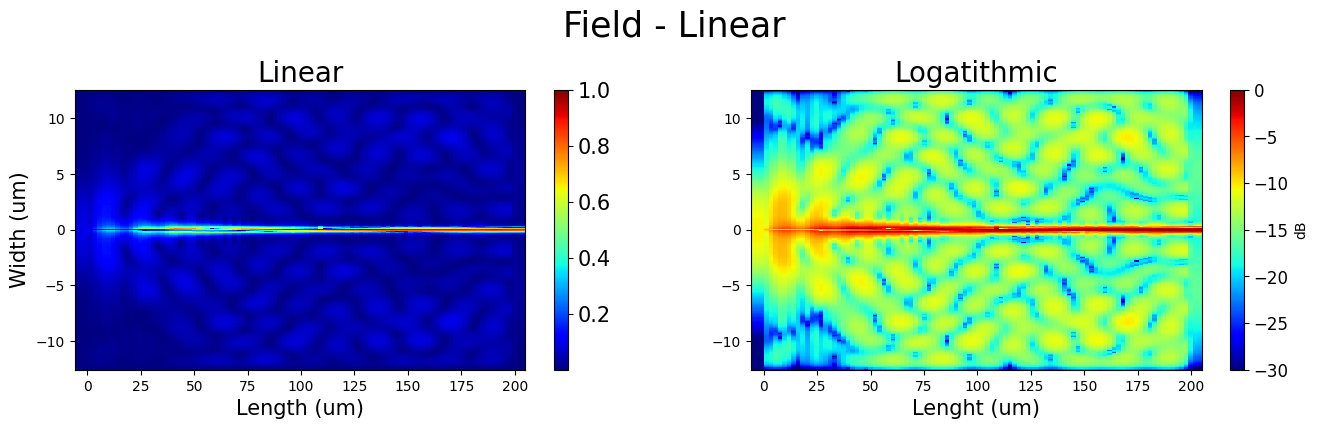

In [5]:
# Plot Linear and Log TE Mode Field Monitor Graph

lum.emepropagate()

figure1 = plt.figure(figsize=(16, 8), edgecolor= 'white', facecolor= 'white')

if fdtd :field = lum.getresult('field','E')
else: field = lum.getresult('field','field profile')

x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E/np.max(E))

plt.suptitle('Field - Linear', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E/np.max(E),cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

E = E/np.max(E)
plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 0)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_LinearTE')

In [6]:
 # Getting transmission results

if fdtd:
    S = lum.getresult('output', 'T')

    T = (S['T'])
    Tlog = 10*np.log10(T)

else:

    lum.setemeanalysis("wavelength sweep",1)
    lum.setemeanalysis("start wavelength",1.5e-6)
    lum.setemeanalysis("stop wavelength",1.6e-6)
    lum.setemeanalysis("number of wavelength points",101)
    lum.emesweep("wavelength sweep")
    S = lum.getemesweep('S_wavelength_sweep')
    T = (abs(S['s21'])**2)
    Tlog = 10*np.log10(T)


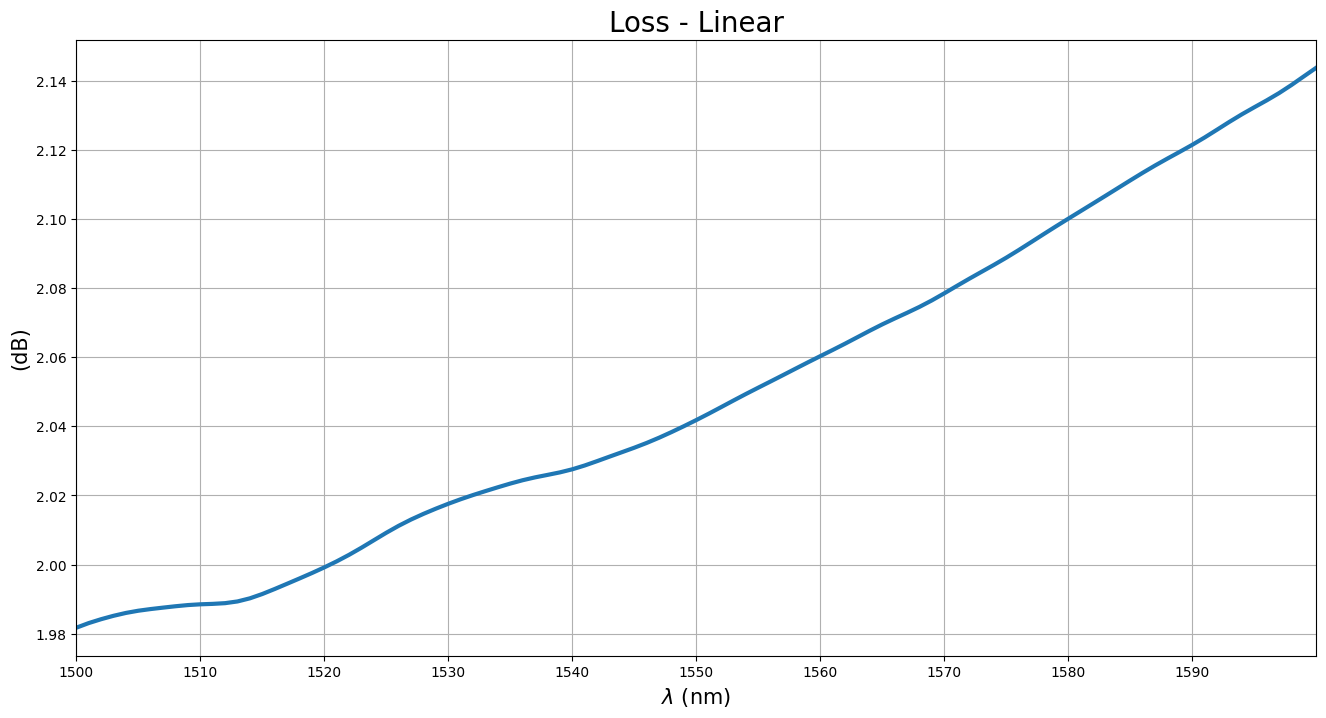

In [7]:

# Plotting insertion loss

figure2 = plt.figure(figsize=(16,8))

plt.title('Loss - Linear', size = 20)
wavelength = np.linspace(1500,1600,len(T))
plt.plot(wavelength, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
#plt.ylim(1.2,1.6)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_LinearTE')

In [9]:
with open('SavedData/Linear_DataTE.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [10]:
with open('SavedData/Linear_DataTE.txt', 'rb') as file:
    Linear_data = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Linear_data) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.635554,0.635631,0.635714,0.635777,0.635808,0.635816,0.635819,0.635821,0.635806,0.63576,...,0.616573,0.616318,0.616056,0.615787,0.615518,0.615253,0.614990,0.614723,0.614444,0.614151
1,-1.968476,-1.967947,-1.967382,-1.966949,-1.966738,-1.966685,-1.966665,-1.966653,-1.966751,-1.96707,...,-2.100155,-2.101948,-2.103799,-2.105693,-2.107590,-2.109462,-2.111318,-2.113207,-2.115180,-2.117246


# Exponential

In [2]:
if fdtd: lum = lumapi.FDTD(filename='../CML/Exponential.fsp')
else: lum = lumapi.MODE(filename='../CML/Exponential.lms')

In [5]:
# Using 0.04μm width for TM and 0.08μm for TE
# Using 200μm lenght

lum.selectall()
lum.delete()


width = 0.02e-6
lenght = 200e-6
N = 100

x = np.linspace(0,lenght,N)
a = (finalwidth/2 / width) ** (1/(N-1))
function = np.array([width * (a ** i) for i in range(N)])

X, Y, xinverse, yinverse = functionstapers(lenght, N, finalwidth, -function)


lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : substratez,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : yspan,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})

lum.addobject('cc_fiber')
lum.set({
    'first axis'  :  'y',
    'rotation 1': 90,
    'index cladding' : 1.46,
    'index core'     : 1.47,
    'radius core'    : 4e-6,
    'radius cladding': 20e-6,
    'z span'         : 20e-6,
    'z'              : height/2,
    'x'              : -10e-6,
    'y'              : 0,
    'name'           : 'fiber'
})


In [6]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)
lum.switchtolayout()
meshmulti = 3
cellsmesh = 250
lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()
lum.select('EME')
lum.delete()
lum.select('full coupler mesh')
lum.delete()
lum.select('extension mesh')
lum.delete()
lum.select('high order mesh')
lum.delete()

if fdtd:
    # Create FDTD
    lum.addpower()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 5e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addpower()
    lum.set('monitor type', '2D X-normal')
    lum.set({
        'z'                               : height/2,
        'z span'                          : zspan,
        'x'                               : length + 2e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'output',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addmode()
    lum.set({
        'x'                : -2.5e-6,
        'y'                : 0,
        'y span'           : yspan,
        'z'                : height/2,
        'z span'           : zspan,
        'name'             : 'port',
        'wavelength start' : 1.5e-6,
        'wavelength stop'  : 1.6e-6
    })

    lum.addfdtd()
    lum.set({
        'z'               : height/2,
        'z span'          : zspan,
        'x'               : length/2,
        'x span'          : length+5e-6,
        'y'               : 0,
        'y span'          : yspan,
        'mesh accuracy'   : 2,
        'y min bc'        : 'PML',
        'z min bc'        : 'Symmetric',
        'y max bc'        : 'PML',
        'z max bc'        : 'PML',
        'simulation time' : time
    })

    
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'core',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'extension',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })

else:

    # Create EME 
    lum.addeme()
    lum.set("allow custom eigensolver settings",1)
    lum.set("number of cell groups",3)
    lum.set("group spans",np.transpose([5e-6, length, 4e-6]))
    lum.set({
        "cells"                   :np.transpose([1, 80, 1]),
        "subcell method"          :np.transpose([0, 1, 0]), # 0 = none,  1 = CVCS
        "modes"                   :np.transpose([4, 32, 4]),
        "x min"                   :-5e-6,
        "y"                       :0,
        "y span"                  :yspan,
        "z"                       :height/2,
        "z span"                  :zspan,
        "y min bc"                :"Anti-Symmetric",
        "y max bc"                :"PML",
        "z min bc"                :"Symmetric",
        "z max bc"                :"PML",
        #"background material"     :"SiO2 (Glass) - Palik",
        "mesh cells y"            :cellsmesh,
        "mesh cells z"            :cellsmesh,
        "display cells"           : 0
        })
    
    lum.addemeprofile()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 10e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
    })

    #Create EME Ports
    lum.select("EME::Ports::port_2")
    lum.set({"use full simulation span" :0,
        "y span"                        :2e-6,
        "z span"                        :5e-6,
        "z"                             :height/2
    })

    lum.select("EME::Ports::port_1")
    lum.set({"use full simulation span" :0,
        "y span"                        :yspan,
        "z span"                        :zspan,
        "z"                             :height/2,
    })

    lum.addmesh()
    lum.set({
        'based on a structure': 1,
        'structure'           : 'core',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti,
        'name'                : 'full coupler mesh'
        })
    lum.addmesh()
    lum.set({
        'based on a structure': 1,
        'structure'           : 'extension',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti,
        'name'                : 'extension mesh'
    })
    lum.addmesh()
    lum.set({
        'name'   : 'high order mesh',
        'x'      : 25e-6,
        'x span' : 50e-6,
        'y'      : 0,
        'y span' : 0.15e-6,
        'z'      : 0,
        'z span' : 0.4e-6,
        'dx'     : 0.003e-6,
        'dy'     : 0.003e-6,
        'dz'     : 0.006e-6,
    })



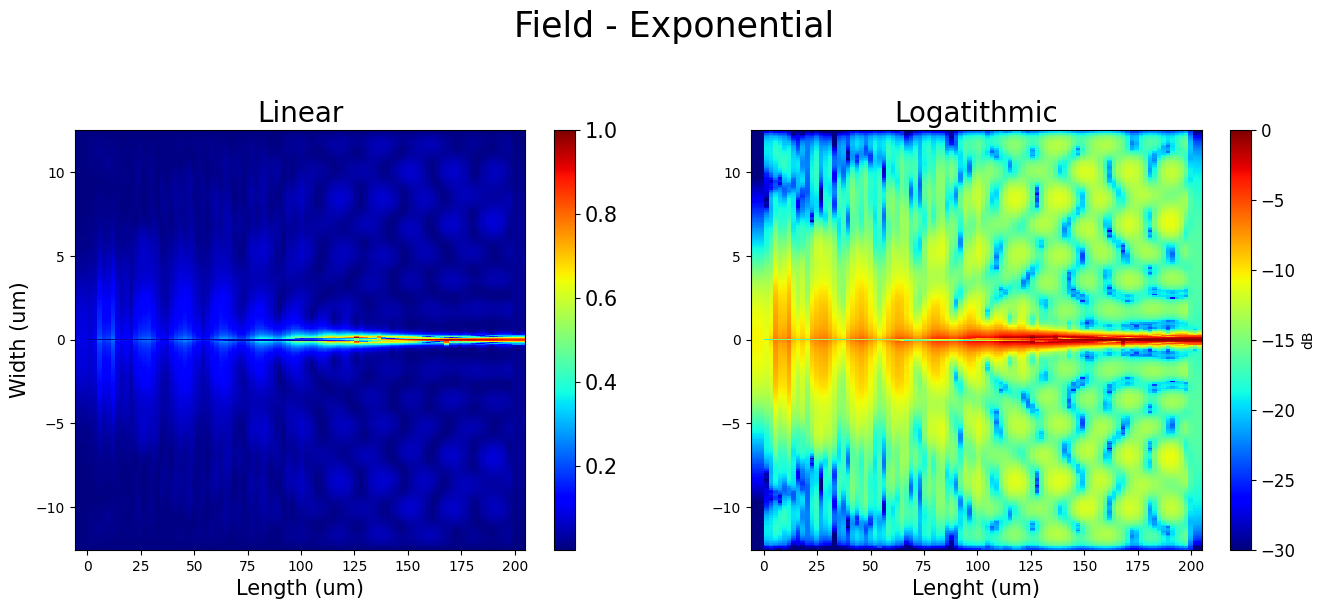

In [7]:
# Plot Linear and Log Field Monitor Graph
lum.emepropagate()

figure3 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

if fdtd :field = lum.getresult('field','E')
else: field = lum.getresult('field','field profile')

x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E/np.max(E))

plt.suptitle('Field - Exponential', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E/np.max(E),cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

E = E/np.max(E)
plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 0)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_ExponentialTM')

In [8]:
 # Getting results

if fdtd:
    S = lum.getresult('output', 'T')

    T = (S['T'])
    Tlog = 10*np.log10(T)

else:

    lum.setemeanalysis("wavelength sweep",1)
    lum.setemeanalysis("start wavelength",1.5e-6)
    lum.setemeanalysis("stop wavelength",1.6e-6)
    lum.setemeanalysis("number of wavelength points",101)
    lum.emesweep("wavelength sweep")
    S = lum.getemesweep('S_wavelength_sweep')
    T = (abs(S['s21'])**2)
    Tlog = 10*np.log10(T)


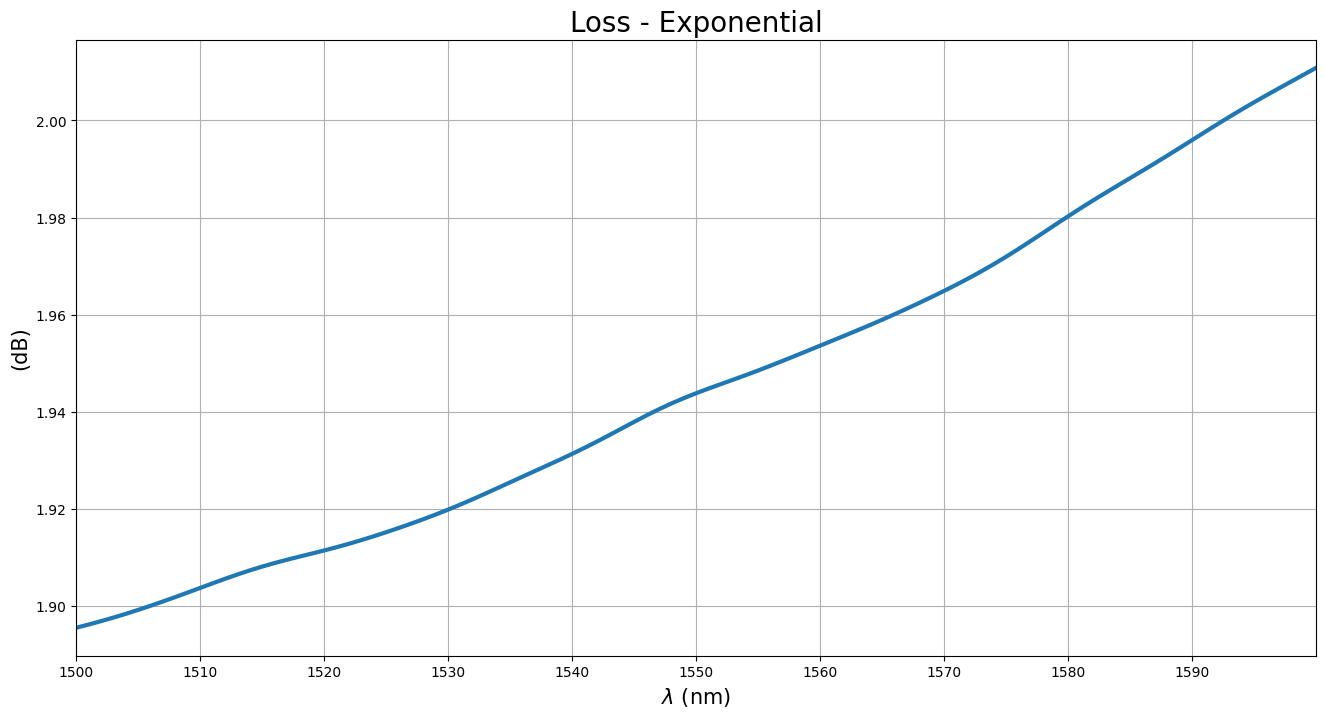

In [9]:
# Plotting transmission and insertion loss

figure4 = plt.figure(figsize=(16,8))
wavelength = np.linspace(1500,1600,len(T))
plt.title('Loss - Exponential', size = 20)

plt.plot(wavelength, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_ExponentialTM')

In [10]:
with open('SavedData/Exponential_DataTM.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [11]:
with open('SavedData/Exponential_DataTM.txt', 'rb') as file:
    Exponential_data = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Exponential_data) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.646317,0.646218,0.646115,0.646006,0.645891,0.645770,0.645643,0.645511,0.645376,0.645237,...,0.631307,0.631075,0.630848,0.630626,0.630410,0.630199,0.629993,0.629789,0.629586,0.629381
1,-1.895547,-1.896209,-1.896902,-1.897635,-1.898409,-1.899224,-1.900076,-1.900961,-1.901873,-1.902805,...,-1.997592,-1.999188,-2.000755,-2.002284,-2.003771,-2.005222,-2.006644,-2.008050,-2.009453,-2.010863


: 

# Quadratic

In [3]:
if fdtd: lum = lumapi.FDTD(filename='../CML/Quadratic.fsp')
else: lum = lumapi.MODE(filename='../CML/Quadratic.lms')

In [20]:
# Using 0.04μm width for TM and 0.08μm for TE
# Using 200μm lenght
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()
lum.select('extension')
lum.delete()
lum.select('fiber')
lum.delete()


width = 0.04e-6
lenght = 200e-6
N = 100

x = np.linspace(0,lenght,N)

a = (finalwidth/2 - width) / ((N-1) ** 2)
function = np.array([width + a * (i ** 2) for i in range(N)])

X, Y, xinverse, yinverse = functionstapers(lenght, N, width, function)

lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})


lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : substratez,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : yspan,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})

lum.addobject('cc_fiber')
lum.set({
    'first axis'  :  'y',
    'rotation 1': 90,
    'index cladding' : 1.46,
    'index core'     : 1.47,
    'radius core'    : 4e-6,
    'radius cladding': 20e-6,
    'z span'         : 20e-6,
    'z'              : height/2,
    'x'              : -10e-6,
    'y'              : 0,
    'name'           : 'fiber'
})

In [21]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)
lum.switchtolayout()
meshmulti = 3
cellsmesh = 250
lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()
lum.select('EME')
lum.delete()
lum.select('full coupler mesh')
lum.delete()
lum.select('extension mesh')
lum.delete()
lum.select('high order mesh')
lum.delete()

if fdtd:
    # Create FDTD
    lum.addpower()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 5e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addpower()
    lum.set('monitor type', '2D X-normal')
    lum.set({
        'z'                               : height/2,
        'z span'                          : zspan,
        'x'                               : length + 2e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'output',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addmode()
    lum.set({
        'x'                : -2.5e-6,
        'y'                : 0,
        'y span'           : yspan,
        'z'                : height/2,
        'z span'           : zspan,
        'name'             : 'port',
        'wavelength start' : 1.5e-6,
        'wavelength stop'  : 1.6e-6
    })

    lum.addfdtd()
    lum.set({
        'z'               : height/2,
        'z span'          : zspan,
        'x'               : length/2,
        'x span'          : length+5e-6,
        'y'               : 0,
        'y span'          : yspan,
        'mesh accuracy'   : 2,
        'y min bc'        : 'PML',
        'z min bc'        : 'Symmetric',
        'y max bc'        : 'PML',
        'z max bc'        : 'PML',
        'simulation time' : time
    })

    
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'core',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'extension',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })

else:

    # Create EME 
    lum.addeme()
    lum.set("allow custom eigensolver settings",1)
    lum.set("number of cell groups",3)
    lum.set("group spans",np.transpose([5e-6, length, 4e-6]))
    lum.set({
        "cells"                   :np.transpose([1, 80, 1]),
        "subcell method"          :np.transpose([0, 1, 0]), # 0 = none,  1 = CVCS
        "modes"                   :np.transpose([4, 32, 4]),
        "x min"                   :-5e-6,
        "y"                       :0,
        "y span"                  :yspan,
        "z"                       :height/2,
        "z span"                  :zspan,
        "y min bc"                :"Anti-Symmetric",
        "y max bc"                :"PML",
        "z min bc"                :"Symmetric",
        "z max bc"                :"PML",
        #"background material"     :"SiO2 (Glass) - Palik",
        "mesh cells y"            :cellsmesh,
        "mesh cells z"            :cellsmesh,
        "display cells"           : 0
        })
    
    lum.addemeprofile()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 10e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
    })

    #Create EME Ports
    lum.select("EME::Ports::port_2")
    lum.set({"use full simulation span" :0,
        "y span"                        :2e-6,
        "z span"                        :5e-6,
        "z"                             :height/2
    })

    lum.select("EME::Ports::port_1")
    lum.set({"use full simulation span" :0,
        "y span"                        :yspan,
        "z span"                        :zspan,
        "z"                             :height/2,
    })

    lum.addmesh()
    lum.set({
        'based on a structure': 1,
        'structure'           : 'core',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti,
        'name'                : 'full coupler mesh'
        })
    lum.addmesh()
    lum.set({
        'based on a structure': 1,
        'structure'           : 'extension',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti,
        'name'                : 'extension mesh'
    })
    lum.addmesh()
    lum.set({
        'name'   : 'high order mesh',
        'x'      : 25e-6,
        'x span' : 50e-6,
        'y'      : 0,
        'y span' : 0.15e-6,
        'z'      : 0,
        'z span' : 0.4e-6,
        'dx'     : 0.003e-6,
        'dy'     : 0.003e-6,
        'dz'     : 0.006e-6,
    })



{!!}

{!!}

{!!}



C:\Program Files\Lumerical\v202\api\python\lumapi.py:138: UserWarning: Multiple objects named '::model::mesh'. Use of this object may give unexpected results.
  warnings.warn(message)


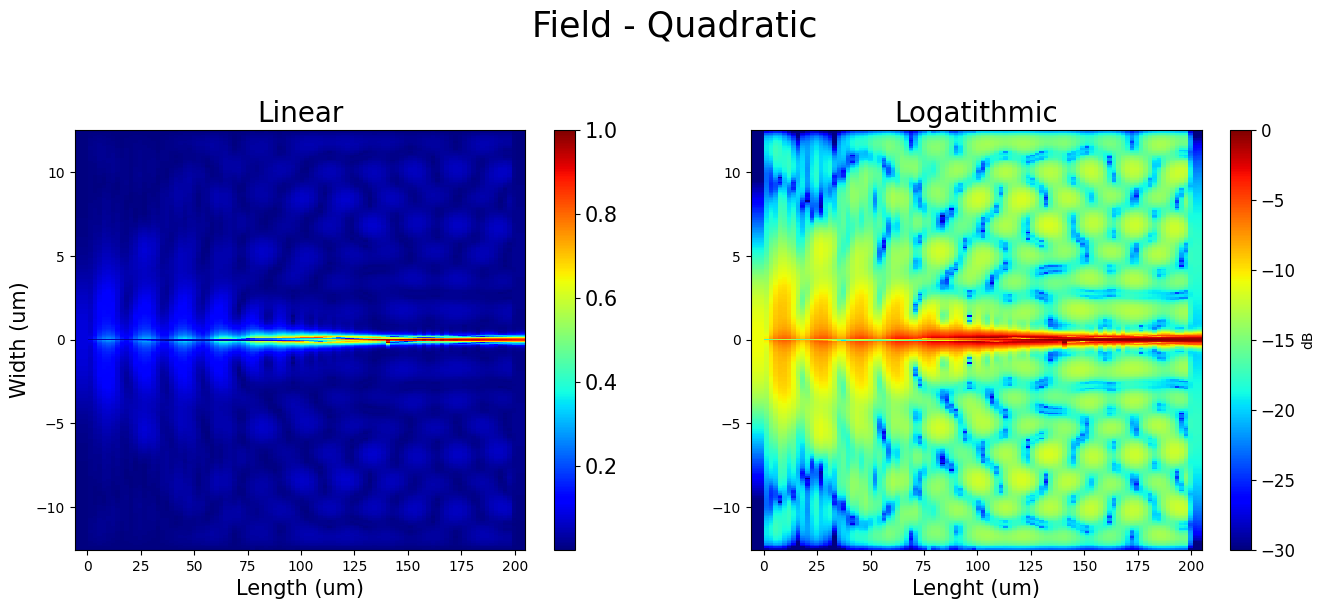

In [22]:
# Plot Linear and Log Mode Field Monitor Graph

figure5 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

lum.emepropagate()

if fdtd :field = lum.getresult('field','E')
else: field = lum.getresult('field','field profile')

x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E/np.max(E))

plt.suptitle('Field - Quadratic', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E/np.max(E),cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

E = E/np.max(E)
plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 0)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_QuadraticTE')

In [23]:
 # Getting results

if fdtd:
    S = lum.getresult('output', 'T')

    T = (S['T'])
    Tlog = 10*np.log10(T)

else:

    lum.setemeanalysis("wavelength sweep",1)
    lum.setemeanalysis("start wavelength",1.5e-6)
    lum.setemeanalysis("stop wavelength",1.6e-6)
    lum.setemeanalysis("number of wavelength points",101)
    lum.emesweep("wavelength sweep")
    S = lum.getemesweep('S_wavelength_sweep')
    T = (abs(S['s21'])**2)
    Tlog = 10*np.log10(T)

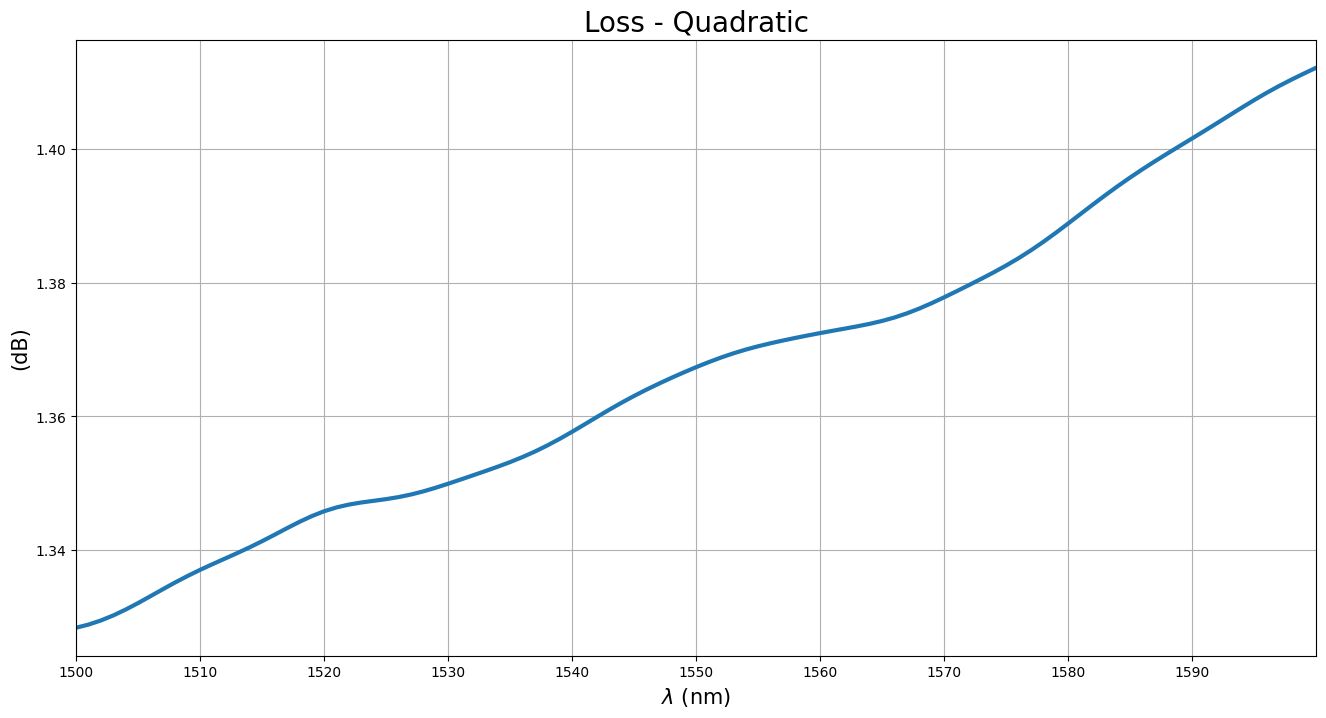

In [24]:
# Plotting transmission and insertion loss

figure6 = plt.figure(figsize=(16,8))
wavelength = np.linspace(1500,1600,len(T))
plt.title('Loss - Quadratic', size = 20)

plt.plot(wavelength, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_QuadraticTE')

In [25]:
with open('SavedData/Quadratic_DataTE.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [26]:
with open('SavedData/Quadratic_DataTE.txt', 'rb') as file:
    Quadratic_data = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Quadratic_data) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.736484,0.736404,0.736300,0.736171,0.736022,0.735857,0.735683,0.735506,0.735333,0.735169,...,0.723974,0.723782,0.723588,0.723395,0.723206,0.723026,0.722856,0.722697,0.722547,0.722400
1,-1.328365,-1.328839,-1.329455,-1.330211,-1.331090,-1.332065,-1.333095,-1.334139,-1.335158,-1.336127,...,-1.402771,-1.403923,-1.405085,-1.406244,-1.407377,-1.408461,-1.409481,-1.410436,-1.411342,-1.412225


# Comparison 


In [3]:
with open('SavedData/Linear_DataTM.txt', 'rb') as file:
    LinTM = plk.load(file)
file.close()

with open('SavedData/Linear_DataTE.txt', 'rb') as file:
    LinTE = plk.load(file)
file.close()

with open('SavedData/Exponential_DataTM.txt', 'rb') as file:
    ExpTM = plk.load(file)
file.close()

with open('SavedData/Exponential_DataTE.txt', 'rb') as file:
    ExpTE = plk.load(file)
file.close()

with open('SavedData/Quadratic_DataTM.txt', 'rb') as file:
    QuaTM = plk.load(file)
file.close()

with open('SavedData/Quadratic_DataTE.txt', 'rb') as file:
    QuaTE = plk.load(file)
file.close()

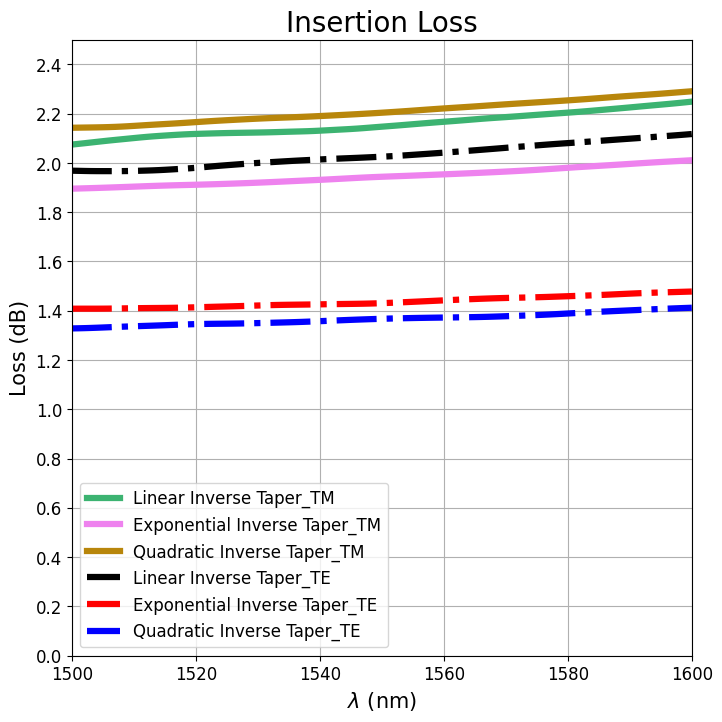

In [9]:
# Plotting mode convergence of the diferent shapes

figure9 = plt.figure(figsize=(8,8))
wavelength = np.linspace(1500,1600,len(LinTM[1]))
plt.title('Insertion Loss', size = 20)

plt.plot(wavelength, -LinTM[1], linewidth = 4.5, label = 'Linear Inverse Taper_TM', color = 'mediumseagreen')
plt.plot(wavelength, -ExpTM[1], linewidth = 4.5, label = 'Exponential Inverse Taper_TM', color = 'violet')
plt.plot(wavelength, -QuaTM[1], linewidth = 4.5, label = 'Quadratic Inverse Taper_TM', color = 'darkgoldenrod')
plt.plot(wavelength, -LinTE[1],linestyle = '-.', linewidth = 4.5, label = 'Linear Inverse Taper_TE', color = 'black')
plt.plot(wavelength, -ExpTE[1],linestyle = '-.', linewidth = 4.5, label = 'Exponential Inverse Taper_TE', color = 'red')
plt.plot(wavelength, -QuaTE[1],linestyle = '-.', linewidth = 4.5, label = 'Quadratic Inverse Taper_TE', color = 'blue')
plt.legend(fontsize=12)
plt.xticks(np.arange(1500,1601,20), size = 12)
plt.xlim(1500,1600)
plt.yticks(np.arange(0,2.5,0.2),size = 12)
plt.ylim(0,2.5)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('Loss (dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_All_Shapes')